In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **French multi-labels texts classification with CNN and Word2vec**

Nous allons analyser les réponses d'un sondage effectué auprès de personnes agées pour avoir leur ressenti sur la pandémie de Covid-19.

Après avoir effectué un word embedding simple (tokenizer et indexation des mots) sur les données et lancé un CNN, nous nous sommes rendus compte qu'il fallait compenser le manque de données d'entrainement par un word embedding pré-entrainé sur la langue française.

Nous allons présenter dans ce notebook les modèles nous ayant donné les meilleurs résultats

# **0.1 Importation des librairies**

In [9]:
import numpy as np
import pandas as pd

import argparse

import matplotlib.pyplot as plt
import re
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer 
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **0.2 Séparation de chaque question en fichier CSV**

In [3]:
input_file = "/content/drive/MyDrive/dataset/Projet/Data-questionnaires.xlsx" # The excel filename to parse
column = "Catégorisation" # Name of category column
split = 500 # Split the file at this row
header_row = 1 # Row number for headers

Questions=['Question_3','Question_5', 'Question_8', 'Question_10', 'Question_14', 'Question_17', 'Question_18', 'Question_20', 'Question_21']
#!mkdir 'DataQuestions'
################################################################################

df = pd.read_excel(input_file, header=header_row-1)

# Split, save and continue without this section
if split:
    index = split - 1
    df_without_category, df = df.iloc[index:], df.iloc[:index - 1]
        
    #question_number = 1
    question_number = 0
    # When "Question" in column name, keep this column and save
    for col in df_without_category.columns:
        if "Question" in col:
            QuetCol = df_without_category[col]
            QuetCol.dropna(how="all", inplace=True)
            QuetCol.to_csv(f"nonlabeled_{Questions[question_number]}.csv")
            question_number += 1

# Remove all lines without 1st question
# df = df[df.iloc[:,0].notna()]

columns = list(df.columns)

# Keep column names
categories = []
data = []

looking = False # Is category column ?
for col in columns:
    if not looking and "Catégorisation" in col:
        looking = True
        category = []
    elif looking and "Unnamed" not in col:
        looking = False
        categories.append(category)
    if looking:
        category.append(col) 
# If last column is still a category
if looking:
    categories.append(category)


new_df = pd.DataFrame()

trn_tst = 0 # Split the file into train and test at this row
Cats_by_Question = []
# Iterate throught all columns
# If data, insert it in new dataframe
# Else process and insert formated category columns
ques = 0
for col in columns:
    if "Question" in col:
        num_question = col[8:]
        #print(num_question)
        new_df[col] = df[col].copy()
    elif "Catégorisation" in col:
        category_columns = categories[ques]
        cat_df = df[category_columns]
        number_of_cat = cat_df.max().max()
        list_cat = [list(row[1].dropna()) for row in cat_df.iterrows()]
        for i in range(1, int(number_of_cat)+1):
            new_df[f"category_{i}"] = pd.Series([1 if i in row else 0 for row in list_cat])
            
        #category_index = Questions[ques] 
            
        if trn_tst:
          index = trn_tst - 1
          df_test, df_train = new_df.iloc[index:], new_df.iloc[:index - 1]
          df_train.dropna(inplace=True)
          df_train.to_csv(f"labeled_Question_{num_question}.csv")
          df_test.dropna(inplace=True)
          df_test.to_csv(f"test_Question_{num_question}.csv")
          cats = df_train.columns[1:].to_list()
        else:
          new_df.to_csv(f"labeled_Question_{num_question}.csv")
          cats = new_df.columns[1:].to_list()

        
        Cats_by_Question.append(cats)
        ques += 1  
        new_df = pd.DataFrame()

# **1.1 Importation et traitement de la question 8**

In [4]:
df_train = pd.read_csv('./labeled_Question_8.csv')
df_train = df_train.dropna(how='all')
df_train = df_train[df_train['Question8'].notna()]
df_train = df_train.reset_index(drop=True)
del df_train['Unnamed: 0']

df_test = pd.read_csv('./nonlabeled_Question_8.csv')
df_test = df_test.dropna(how='all')
df_test = df_test[df_test['Question8'].notna()]
df_test = df_test.reset_index(drop=True)
del df_test['Unnamed: 0']

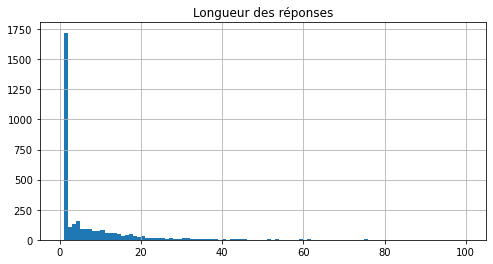

In [6]:
reponses_word_count = []

for i in df_train['Question8']:
      reponses_word_count.append(len(i.split()))

for i in df_test['Question8']:
      reponses_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Longueur des réponses':reponses_word_count})

length_df.hist(bins = 100, range=(0,100),figsize=(8,4))
plt.show()

On remarque que les réponses sont assez courtes avec beaucoup de réponses d'un mot (oui ou non).

In [10]:
stop_words = set(stopwords.words('french'))

def clean_reponses(df):
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  #retire la ponctuation
  tokens = [re_punc.sub(' ',reponse) for reponse in df]
  #convertit en minuscules
  tokens = [reponse.lower() for reponse in tokens]
  
  #split chaque réponse en liste de mots
  reponses = []
  reponses = [reponse.split() for reponse in tokens]
  
  #suppression des stop_words
  for reponse in reponses:
    for word in reponse:
      if word in stop_words:
        del reponse[reponse.index(word)]
        
  #suppression des mots de longueur <= 2
  for reponse in reponses:
    for word in reponse:
      if len(word) <= 2:
        del reponse[reponse.index(word)]
  return reponses

In [11]:
rep_train = clean_reponses(df_train['Question8'])
rep_test = clean_reponses(df_test['Question8'])
l=[]

for reponse in rep_train:
  for word in reponse:
    l.append(word)

for reponse in rep_test:
  for word in reponse:
    l.append(word)

#on affiche les mots les plus fréquents
fdist = nltk.FreqDist(l)
fdist.most_common(50)

[('non', 2133),
 ('oui', 566),
 ('plus', 227),
 ('faire', 131),
 ('être', 111),
 ('car', 111),
 ('tout', 106),
 ('peut', 103),
 ('est', 103),
 ('confinement', 102),
 ('peu', 98),
 ('pense', 96),
 ('manque', 91),
 ('autonomie', 89),
 ('marche', 84),
 ('cela', 76),
 ('physique', 75),
 ('suis', 74),
 ('les', 74),
 ('fait', 72),
 ('une', 72),
 ('bien', 70),
 ('activités', 70),
 ('moins', 69),
 ('pas', 66),
 ('très', 63),
 ('courses', 60),
 ('perte', 59),
 ('pour', 58),
 ('nous', 56),
 ('perdre', 54),
 ('santé', 54),
 ('ans', 54),
 ('vie', 51),
 ('instant', 50),
 ('des', 50),
 ('marcher', 49),
 ('sans', 49),
 ('mon', 48),
 ('comme', 48),
 ('fais', 46),
 ('longtemps', 43),
 ('moment', 42),
 ('sortir', 40),
 ('cas', 39),
 ('liberté', 39),
 ('beaucoup', 39),
 ('physiques', 38),
 ('temps', 38),
 ('risque', 37)]

# **1.2 Descriptions des catégories de la question 8**

A partir du fichier Word fournit, nous avons décidé d'affecter à chaque catégorie des mots-clés.

Ces mots clés pourront ensuite être utilisé par le Word2Vec pré-entrainé et le réseau de neurones pour identifier une sémantique proche.

In [12]:
descriptions_categories = [ ('oui', 1,0,0,0,0,0,0),
                           ('oui un peu peut être possible', 0,1,0,0,0,0,0),
                           ('non', 0,0,1,0,0,0,0),
                           ('non sauf mais si peut être', 0,0,0,1,0,0,0),
                           ('cela dépendra dépendre durée trop long longtemps manque temps', 0,0,0,0,1,0,0),
                           ('je ne sais pas', 0,0,0,0,0,1,0),
                           ('non grande autonomie plus organiser faire', 0,0,0,0,0,0,1)]
descriptions_df = pd.DataFrame(descriptions_categories, columns = ['Question8' , 'category_1', 'category_2','category_3', 'category_4', 'category_5','category_6','category_7'])
descriptions_df

,Question8,category_1,category_2,category_3,category_4,category_5,category_6,category_7
0,oui,1,0,0,0,0,0,0
1,oui un peu peut être possible,0,1,0,0,0,0,0
2,non,0,0,1,0,0,0,0
3,non sauf mais si peut être,0,0,0,1,0,0,0
4,cela dépendra dépendre durée trop long longtem...,0,0,0,0,1,0,0
5,je ne sais pas,0,0,0,0,0,1,0
6,non grande autonomie plus organiser faire,0,1,0,0,0,0,1


In [13]:
df_train=df_train.append(descriptions_df,ignore_index=True)

Ce dataframe de descriptions des catégories a ensuité été ajouté au dataframe des données d'entrainement, cette action s'est révélée efficace car notre test_accuracy est passé de 0.7 à 0.8 et le modèle a mieux prédis certaines catégories où les données étaient faibles

# **2. Word embedding avec un Word2Vec de la langue française**

Nous avons téléchargé un word2vec de la langue française pré-entrainé sur des pages web (notamment celles du journal Le Monde). Plusieurs word2vec étaient disponibles, nous avons choisi un "skip" au lieu d'un CBOW (bag of words) car il est mieux destiné à prédire le contexte d'un mot. 

Lien de téléchargement: https://fauconnier.github.io/

Modèle: bin (120Mb) skip 200 (dim) 100 (cutoff)

**2.1 Chargement et présentation du modèle**

In [15]:
# import Word2Vec loading capabilities
from gensim.models import KeyedVectors

# Creating the model
embed_lookup = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/dataset/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin', 
                                                 binary=True)

In [16]:
# store pretrained vocab
pretrained_words = []
for word in embed_lookup.vocab:
    pretrained_words.append(word)

In [17]:
row_idx = 1

# get word/embedding in that row
word = pretrained_words[row_idx] # get words by index
embedding = embed_lookup[word] # embeddings by word

# vocab and embedding info
print("Taille du vocabulaire: {}\n".format(len(pretrained_words)))
print('Taille des vecteurs de mot: {}\n'.format(len(embedding)))
#print('Associated embedding: \n', embedding)

Taille du vocabulaire: 155562

Taille des vecteurs de mot: 200



In [18]:
#Test de la similarité d'un mot
find_similar_to = 'plus'

print('Mots similaires à '+find_similar_to+': \n')

# Find similar words, using cosine similarity
# by default shows top 10 similar words
for similar_word in embed_lookup.similar_by_word(find_similar_to):
    print("Mot: {0}, Similarité: {1:.3f}".format(
        similar_word[0], similar_word[1]
    ))

Mots similaires à plus: 

Mot: encore, Similarité: 0.820
Mot: peu, Similarité: 0.808
Mot: moins, Similarité: 0.795
Mot: surtout, Similarité: 0.788
Mot: seulement, Similarité: 0.783
Mot: aussi, Similarité: 0.781
Mot: très, Similarité: 0.751
Mot: pratiquement, Similarité: 0.747
Mot: mais, Similarité: 0.742
Mot: relativement, Similarité: 0.732


**2.2 Word embedding des réponses à la question 8**

In [19]:
def tokenize_reponses(embed_lookup, reviews_split):
  
  reponses = clean_reponses(reviews_split)

  tokenized_reponses = []
  for reponse in reponses:
    ints = []
    for mot in reponse:
      #si le mot est dans le vocab du word2vec alors on récupère son vecteur sinon 0
      try:
        idx = embed_lookup.vocab[mot].index
      except: 
        idx = 0
      ints.append(idx)
    tokenized_reponses.append(ints)
  return tokenized_reponses

tokenized_reponses_train = tokenize_reponses(embed_lookup, df_train['Question8'])
tokenized_reponses_test = tokenize_reponses(embed_lookup, df_test['Question8'])

# testing code and printing a tokenized review
print('Avant:', df_train['Question8'][1])
print('Après:', tokenized_reponses_train[1])

#on a attribué à chaque mot d'une réponse son index dans le vocabulaire du word2vec

Avant: non pas dans un avenir proche
Après: [87, 16, 727, 1086]


## 2.3 Padding des sequences obtenues

In [20]:
# Padding with zero
features_train=pad_sequences(tokenized_reponses_train,maxlen=200,padding='post')
features_test=pad_sequences(tokenized_reponses_test,maxlen=200,padding='post')
#features_train[0]

## 2.4 Séparation en train et valid sets

In [21]:
# Installing for Stratified Split
!pip install iterative-stratification

In [22]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [23]:
msss=MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

In [24]:
y_train=df_train[['category_1','category_2','category_3','category_4','category_5','category_6','category_7']].values
print('Shape of Training Labels=>',y_train.shape)

Shape of Training Labels=> (406, 7)


In [25]:
for train_index, val_index in msss.split(features_train, y_train):
    # Creating Train Set
    x_train_split,y_train_split=features_train[train_index],y_train[train_index]
    # Creating Test Set
    x_valid_split,y_valid_split=features_train[val_index],y_train[val_index]

In [26]:
print('Shape of Train Split=>',x_train_split.shape,y_train_split.shape)
print('Shape of Validation Split=>',x_valid_split.shape,y_valid_split.shape)

Shape of Train Split=> (324, 200) (324, 7)
Shape of Validation Split=> (82, 200) (82, 7)


In [27]:
print('Class Distribution of Train Split in Percentage')
for i,v in enumerate(['category_1','category_2','category_3','category_4','category_5','category_6','category_7']):
    print(v)
    print(pd.Series(y_train_split[:,i]).value_counts(normalize=True)*100)

Class Distribution of Train Split in Percentage
category_1
0    89.506173
1    10.493827
dtype: float64
category_2
0    94.135802
1     5.864198
dtype: float64
category_3
1    65.432099
0    34.567901
dtype: float64
category_4
0    94.753086
1     5.246914
dtype: float64
category_5
0    94.444444
1     5.555556
dtype: float64
category_6
0    98.765432
1     1.234568
dtype: float64
category_7
0    98.765432
1     1.234568
dtype: float64


In [28]:
print('Class Distribution of Validation Split in Percentage')
for i,v in enumerate(['category_1','category_2','category_3','category_4','category_5','category_6','category_7']):
    print(v)
    print(pd.Series(y_valid_split[:,i]).value_counts(normalize=True)*100)

Class Distribution of Validation Split in Percentage
category_1
0    89.02439
1    10.97561
dtype: float64
category_2
0    93.902439
1     6.097561
dtype: float64
category_3
1    65.853659
0    34.146341
dtype: float64
category_4
0    95.121951
1     4.878049
dtype: float64
category_5
0    95.121951
1     4.878049
dtype: float64
category_6
0    98.780488
1     1.219512
dtype: float64
category_7
0    98.780488
1     1.219512
dtype: float64


On peut remarquer ici que certaines catégories sont très peu labelisées, raison de plus pour laquelle nous avons ajouté un descriptif des catégories aux données d'entrainement (partie 1.2)

# **3. Modeling**

Nous allons construire un CNN 1D, les vecteurs de chaque mot du Word2Vec pre-entrainé seront dans une première couche Embedding.

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.initializers import Constant

vocab_size = 155562
max_length = 200
embeddings_weights = embed_lookup.vectors
embeddings_dim = 200

# define the model
model = Sequential()
model.add(Embedding(vocab_size, embeddings_dim, input_length=max_length,
                        embeddings_initializer=Constant(embeddings_weights),trainable=True))
# model.add(Embedding(vocab_size, embeddings_dim, input_length=max_length))
model.add(Conv1D(filters=352, kernel_size=7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # summarize defined model
model.summary()
# plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          31112400  
_________________________________________________________________
conv1d (Conv1D)              (None, 194, 352)          493152    
_________________________________________________________________
global_max_pooling1d (Global (None, 352)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               45184     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 31,651,639
Trainable params: 31,651,639
Non-trainable params: 0
_________________________________________________________________


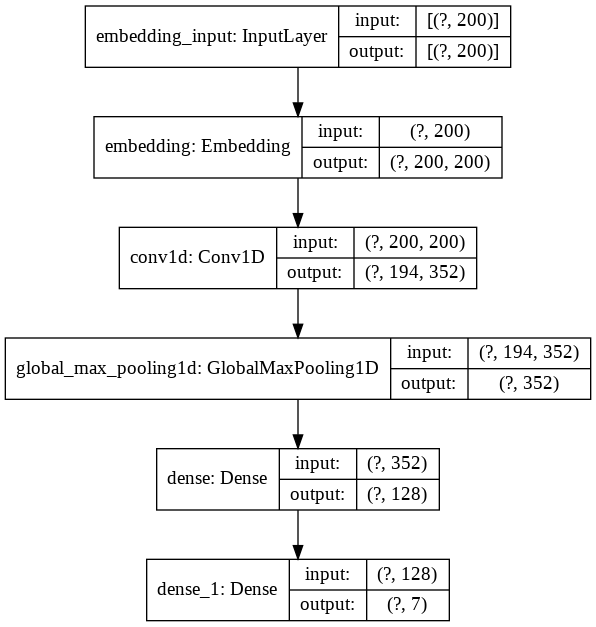

In [30]:
plot_model(model, to_file= 'model.png', show_shapes=True)

In [31]:
# Compile Model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

In [32]:
model.fit(x_train_split,y_train_split, batch_size=512, epochs=100, verbose=1, validation_data=(x_valid_split,y_valid_split))

Epoch 1/100
1/1 [==============================] - 0s 169ms/step - loss: 0.6974 - accuracy: 0.0988 - val_loss: 0.6380 - val_accuracy: 0.6341
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 0.6426 - accuracy: 0.6821 - val_loss: 0.5951 - val_accuracy: 0.6585
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.6033 - accuracy: 0.6852 - val_loss: 0.5565 - val_accuracy: 0.6585
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5657 - accuracy: 0.6852 - val_loss: 0.5192 - val_accuracy: 0.6585
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5279 - accuracy: 0.6914 - val_loss: 0.4824 - val_accuracy: 0.6585
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 0.4898 - accuracy: 0.6914 - val_loss: 0.4468 - val_accuracy: 0.6585
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.4519 - accuracy: 0.6914 - val_loss: 0.4126 - val_accuracy: 0.6585
Epoch 8/100
1/1 [==

In [34]:
# Evalute the trained model, using the test data (20% of the dataset)
score = model.evaluate(x_valid_split, y_valid_split, batch_size=512)

# Final testing accuracy, using the resevered 20% testing data
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.7927
Test accuracy: 0.792682945728302


# **4. Prédiction**

In [35]:
# In-sample Evaluation
train_pred=model.predict(x_train_split)
print('In-sample Evaluation ROC-AUC Score:\n',roc_auc_score(y_train_split,train_pred))

In-sample Evaluation ROC-AUC Score:
 0.9921766779202615


In [36]:
# Out-of-sample Evaluation
valid_pred=model.predict(x_valid_split)
print('In-sample Evaluation ROC-AUC Score:\n',roc_auc_score(y_valid_split,valid_pred))

In-sample Evaluation ROC-AUC Score:
 0.8882064605564278


In [35]:
final_pred=model.predict(features_test)

In [36]:
#Dataframe for final probabilties
prob=pd.DataFrame(columns=['Question8','category_1','category_2','category_3','category_4','category_5','category_6','category_7'])
prob['Question8']=df_test['Question8']
for index,value in enumerate(['category_1','category_2','category_3','category_4','category_5','category_6','category_7']):
    prob[value]=final_pred[:,index]

In [37]:
prob

,Question8,category_1,category_2,category_3,category_4,category_5,category_6,category_7
0,non,0.000218,0.000069,0.956917,0.011561,0.000016,0.000273,0.000140
1,Je n'ai besoin d'aucune aide et le confinement...,0.000029,0.001652,0.001977,0.000055,0.000160,0.000037,0.000055
2,Non,0.000218,0.000069,0.956917,0.011561,0.000016,0.000273,0.000140
3,"oui,car dépendant,mes enfants tenant a ce que ...",0.123496,0.000118,0.000168,0.000121,0.000046,0.000016,0.000011
4,"Oui. Plus de promenades, plus de déambulations...",0.665745,0.005359,0.000080,0.001165,0.002100,0.000780,0.000421
...,...,...,...,...,...,...,...,...
2915,oui bien entendu,0.097322,0.019161,0.035762,0.000279,0.001647,0.001733,0.000346
2916,Sur le long terme ...oui,0.010972,0.001017,0.000063,0.000245,0.972101,0.001051,0.000384
2917,le manque de relations sociales peut faire que...,0.000015,0.000531,0.007994,0.002416,0.000073,0.000046,0.000175
2918,non,0.000218,0.000069,0.956917,0.011561,0.000016,0.000273,0.000140


On remarque que le word2vec a bien aidé à prédire la réponse 2916 en attribuant la catégorie 5 qui se rapproche des mots clés (long, durée etc.)

Sur certaines réponses où les probabilités peuvent paraître très faibles pour chaque catégorie, la prédiction reste bonne par exemple sur la réponse 3.

In [38]:
predictions=pd.DataFrame(columns=['Question8','Prédiction'])
predictions['Question8']=df_test['Question8']

for i in range(len(final_pred)):
    maxi = np.where(final_pred[i] == np.max(final_pred[i]))
    predictions['Prédiction'][i]=maxi[0]+1
    
predictions

,Question8,Prédiction
0,non,[3]
1,Je n'ai besoin d'aucune aide et le confinement...,[3]
2,Non,[3]
3,"oui,car dépendant,mes enfants tenant a ce que ...",[1]
4,"Oui. Plus de promenades, plus de déambulations...",[1]
...,...,...
2915,oui bien entendu,[1]
2916,Sur le long terme ...oui,[5]
2917,le manque de relations sociales peut faire que...,[3]
2918,non,[3]


On peut conclure que le modèle est bon mais peut encore être perfectionné en ajoutant des mots clés aux descriptifs des catégories et en ajoutant des données labelisées